In [1]:
import numpy as np
import numpy_financial as npf
import random
import pandas as pd
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Valuing the market
sp_df = pd.read_excel('spearn.csv', sheet_name='Sheet1')

In [3]:
clean_df = sp_df.drop([i for i in range(6)], axis=0)
rename_dict = {}
for i in sp_df.columns:
    rename_dict[i] = sp_df.loc[6,i]
clean_df = clean_df.rename(rename_dict, axis=1)
clean_df = clean_df.drop(6, axis=0)
clean_df = clean_df.drop(clean_df.index[-1], axis=0)
clean_df = clean_df.set_index('Year')
clean_df['earnings_growth'] = clean_df['Earnings']/clean_df['Earnings'].shift(1)-1
clean_df['dividend_growth'] = clean_df['Dividends']/clean_df['Dividends'].shift(1)-1
clean_df['earnings_10yr_mean_growth'] = clean_df['earnings_growth'].expanding(10).mean()
clean_df['dividends_10yr_mean_growth'] = clean_df['dividend_growth'].expanding(10).mean()

In [4]:
clean_df.tail(20).mean()

Earnings Yield                   0.054790
Dividend Yield                   0.019026
S&P 500                       1618.401000
Earnings                        87.826000
Dividends                       30.796286
Payout Ratio                     0.352274
earnings_growth                  0.077716
dividend_growth                  0.069328
earnings_10yr_mean_growth        0.079629
dividends_10yr_mean_growth       0.056684
dtype: float64

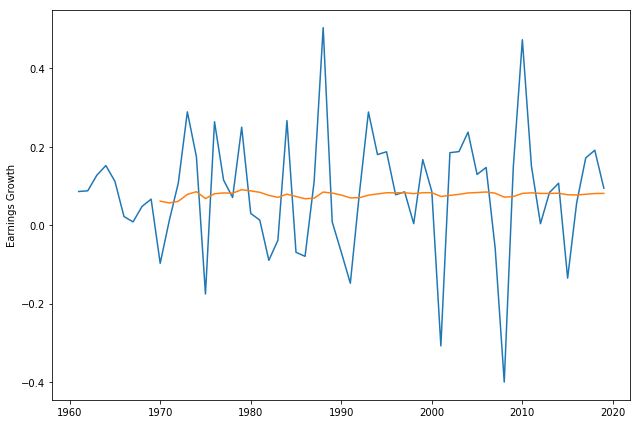

In [5]:
plt.subplots(figsize=(9,6))
plt.plot(clean_df['earnings_growth'], label='Year over Year Earnings Growth')
plt.plot(clean_df['earnings_10yr_mean_growth'], label='Rolling 10 Year Mean')
plt.ylabel('Earnings Growth')
plt.tight_layout()
plt.savefig('eps_growth',bpi=150)

In [6]:
# Base case valuation of S&P 500

valuations = []

terminal_growth = 0.04
discount_rate = 0.08
payout_ratio = 0.50

eps_growth_2020 = (11.88+17.76+28.27+31.78)/(34.95+35.08+33.99+35.72)-1
eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 28.27+31.78+32.85+36.77
eps_growth = [0, (clean_df.iloc[-1]['Earnings'])/eps_next-1,
              0.18,0.14,0.10,0.08,0.08,0.08,0.08,0.08]

value_df = pd.DataFrame()
value_df['earnings'] = (np.array(eps_growth)+1).cumprod()*eps_next
value_df['dividends'] = payout_ratio*value_df['earnings']
value_df['year'] = [i for i in range(2021,2031)]
value_df.set_index('year', inplace=True)

pv_dividends = 0
pv_list = []
for i in range(value_df.shape[0]):
    pv_dividends += value_df['dividends'].iloc[i]/(1+discount_rate)**i
    pv_list.append(value_df['dividends'].iloc[i]/(1+discount_rate)**i)
    
terminal_value = value_df['dividends'].iloc[-1]*(1+terminal_growth)/(discount_rate-terminal_growth)

print('Fair Value: ', pv_dividends + terminal_value/(1+discount_rate)**10)
valuations.append(pv_dividends + terminal_value/(1+discount_rate)**10)

Fair Value:  2964.0135905822817


In [7]:
value_df['all_payouts'] = value_df['dividends']
value_df.loc[2030,'all_payouts']+=terminal_value
value_df['Present Values'] = pv_list
value_df.loc[2030,'Present Values']+=terminal_value/(1+discount_rate)**10

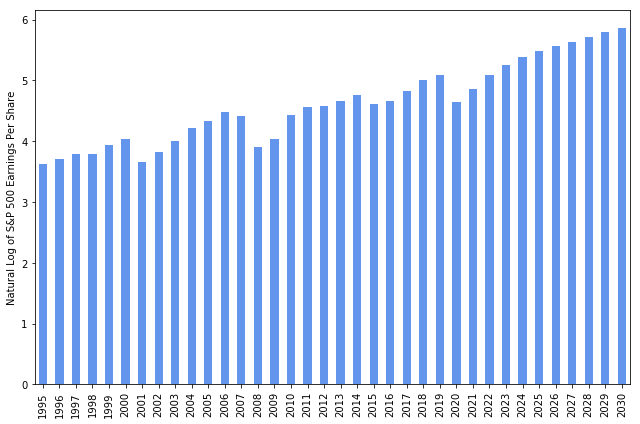

In [8]:
log_earnings = pd.DataFrame()
log_earnings['earnings'] = pd.concat([clean_df.tail(25)['Earnings'],
                                      pd.Series([eps_2020], index=[2020]),
                                      value_df['earnings']], axis=0)
log_earnings['log_earnings'] = log_earnings['earnings']

ax = log_earnings['earnings'].apply(lambda x: np.log(x)).plot(kind='bar', figsize=(9,6), 
                                                              color='cornflowerblue');
ax.set_ylabel('Natural Log of S&P 500 Earnings Per Share');
plt.tight_layout()
plt.savefig('eps_log_scenario', bpi=150)

In [9]:
# Calculate IRR - a.k.a. the discount rate implied by base case cashflows

npf.irr(np.append(np.array(-3348),np.array(value_df['all_payouts'])))

0.06277618427897802

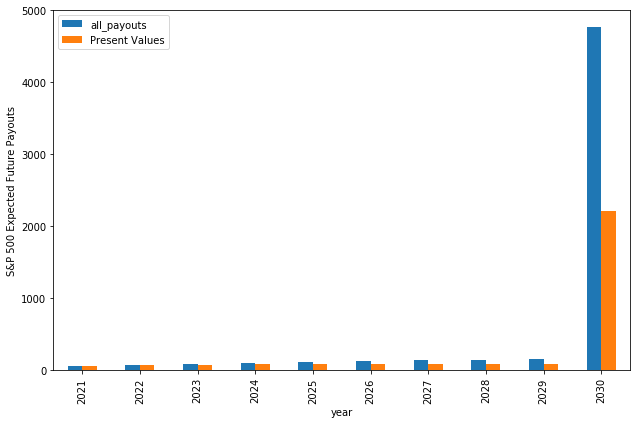

In [10]:
ax = value_df[['all_payouts','Present Values']].plot(kind='bar', figsize=(9,6));
ax.set_ylabel('S&P 500 Expected Future Payouts');
plt.tight_layout()
plt.savefig('payouts', bpi=150)

In [11]:
# Slower recovery

eps_growth_2020 = (11.88+17.76+25+25)/(34.95+35.08+33.99+35.72)-1
bad_eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 24*4
eps_growth = [0,0.15,0.22,0.20,0.16,0.13,0.11,0.09,0.08,0.08]

bad_df = pd.DataFrame()
bad_df['earnings'] = (np.array(eps_growth)+1).cumprod()*eps_next
bad_df['dividends'] = payout_ratio*bad_df['earnings']
bad_df['year'] = [i for i in range(2021,2031)]
bad_df.set_index('year', inplace=True)

pv_dividends = 0
for i in range(bad_df.shape[0]):
    pv_dividends += bad_df['dividends'].iloc[i]/(1+discount_rate)**i
    
terminal_value = bad_df['dividends'].iloc[-1]*(1+terminal_growth)/(discount_rate-terminal_growth)

print('Fair Value: ', pv_dividends + terminal_value/(1+discount_rate)**10)
valuations.append(pv_dividends + terminal_value/(1+discount_rate)**10)

Fair Value:  2460.7594964540267


In [12]:
# Double dip

eps_growth_2020 = (11.88+17.76+25+25)/(34.95+35.08+33.99+35.72)-1
worst_eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 24*4
eps_growth = [0,-0.1,0,0.25,0.25,0.15,0.12,0.10,0.08,0.08]

worst_df = pd.DataFrame()
worst_df['earnings'] = (np.array(eps_growth)+1).cumprod()*eps_next
worst_df['dividends'] = payout_ratio*worst_df['earnings']
worst_df['year'] = [i for i in range(2021,2031)]
worst_df.set_index('year', inplace=True)

pv_dividends = 0
for i in range(worst_df.shape[0]):
    pv_dividends += worst_df['dividends'].iloc[i]/(1+discount_rate)**i
    
terminal_value = worst_df['dividends'].iloc[-1]*(1+terminal_growth)/(discount_rate-terminal_growth)

print('Fair Value: ', pv_dividends + terminal_value/(1+discount_rate)**10)
valuations.append(pv_dividends + terminal_value/(1+discount_rate)**10)

Fair Value:  1835.9102095403562


In [13]:
earnings_scenarios = pd.DataFrame()
earnings_scenarios['actual'] = pd.concat([clean_df.tail(15)['Earnings'],
                                          pd.Series([eps_2020], index=[2020]),
                                          value_df['earnings']*0], axis=0)
earnings_scenarios['base_estimate'] = pd.concat([clean_df.tail(15)['Earnings']*0,
                                                 pd.Series([eps_2020], index=[2020])*0,
                                                 value_df['earnings']], axis=0)
earnings_scenarios['bad_estimate'] = pd.concat([clean_df.tail(15)['Earnings']*0,
                                                pd.Series([bad_eps_2020], index=[2020])*0,
                                                bad_df['earnings']], axis=0)
earnings_scenarios['worst_estimate'] = pd.concat([clean_df.tail(15)['Earnings']*0,
                                                  pd.Series([worst_eps_2020], index=[2020])*0,
                                                  worst_df['earnings']], axis=0)

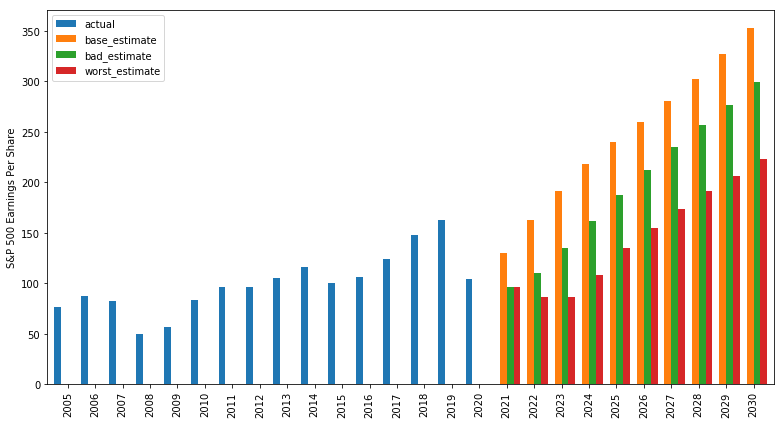

In [14]:
ax = earnings_scenarios.plot(kind='bar', figsize=(11,6), width=1);
ax.set_ylabel('S&P 500 Earnings Per Share');
plt.tight_layout()
plt.savefig('eps_scenario', bpi=150)

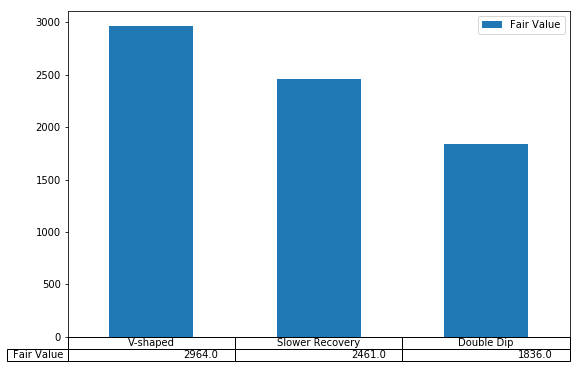

In [15]:
ax = pd.DataFrame([round(i) for i in valuations], 
                  index=['V-shaped','Slower Recovery','Double Dip'],
                  columns=['Fair Value']).plot(kind='bar', table=True, figsize=(9,6));
ax.get_xaxis().set_visible(False)
plt.savefig('valuation_scenarios', bpi=150)

In [16]:
def get_value(tg, dr, eps_growth, eps_next):
    terminal_growth = tg
    discount_rate = dr
    payout_ratio = 0.50

    value_df = pd.DataFrame()
    value_df['earnings'] = (np.array(eps_growth)+1).cumprod()*eps_next
    value_df['dividends'] = payout_ratio*value_df['earnings']
    value_df['year'] = [i for i in range(2021,2031)]
    value_df.set_index('year', inplace=True)

    pv_dividends = 0
    pv_list = []
    for i in range(value_df.shape[0]):
        pv_dividends += value_df['dividends'].iloc[i]/(1+discount_rate)**i
        pv_list.append(value_df['dividends'].iloc[i]/(1+discount_rate)**i)

    terminal_value = value_df['dividends'].iloc[-1]*(1+terminal_growth)/(discount_rate-terminal_growth)
    
    return (pv_dividends + terminal_value/(1+discount_rate)**10)

In [17]:
# Valuation range

eps_growths = []
eps_nexts = []

# Double dip EPS growth
eps_growth_2020 = (11.88+17.76+25+25)/(34.95+35.08+33.99+35.72)-1
worst_eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 24*4
eps_growth = [0,-0.1,0,0.25,0.25,0.15,0.12,0.10,0.08,0.08]
eps_growths.append(eps_growth)
eps_nexts.append(eps_next)

# Slow recovery EPS growth
eps_growth_2020 = (11.88+17.76+25+25)/(34.95+35.08+33.99+35.72)-1
bad_eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 24*4
eps_growth = [0,0.15,0.22,0.20,0.16,0.13,0.11,0.09,0.08,0.08]
eps_growths.append(eps_growth)
eps_nexts.append(eps_next)

# V-shaped EPS growth
eps_growth_2020 = (11.88+17.76+28.27+31.78)/(34.95+35.08+33.99+35.72)-1
eps_2020 = clean_df.iloc[-1]['Earnings']*(1+eps_growth_2020)
eps_next = 28.27+31.78+32.85+36.77
eps_growth = [0, (clean_df.iloc[-1]['Earnings'])/eps_next-1,
              0.18,0.14,0.10,0.08,0.08,0.08,0.08,0.08]
eps_growths.append(eps_growth)
eps_nexts.append(eps_next)

dr_range = np.arange(0.065,0.09,0.005)

all_valuations = []
for index, eps_growth in enumerate(eps_growths):
    dr_valuations = []
    for dr in dr_range:
        dr_valuations.append(round(get_value(0.04, dr, eps_growth, eps_nexts[index])))
    all_valuations.append(dr_valuations)

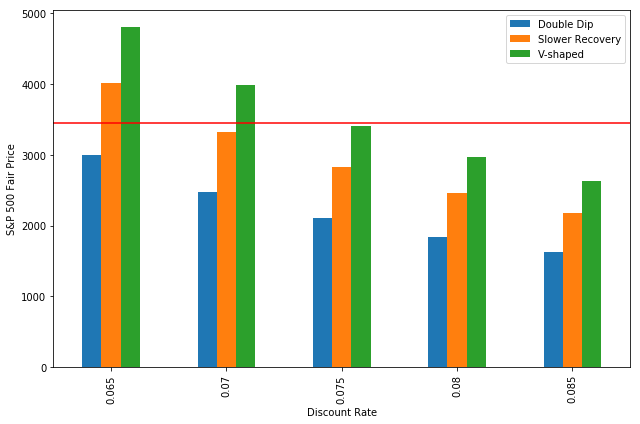

In [18]:
ax = pd.DataFrame(all_valuations, index=['Double Dip','Slower Recovery','V-shaped'],
                  columns=[round(i,3) for i in dr_range]).T.plot(kind='bar', figsize=(9,6));
# ax.get_xaxis().set_visible(False)
plt.axhline(3446, c='red')
ax.set_xlabel('Discount Rate')
ax.set_ylabel('S&P 500 Fair Price')
plt.tight_layout()
plt.savefig('probable_valuation_range', bpi=150)

In [19]:
print(pd.DataFrame(all_valuations, index=['Double Dip','Slower Recovery','V-shaped'],
                   columns=[round(i,3) for i in dr_range]))

                  0.065   0.070   0.075   0.080   0.085
Double Dip       2999.0  2481.0  2112.0  1836.0  1622.0
Slower Recovery  4021.0  3326.0  2831.0  2461.0  2174.0
V-shaped         4807.0  3987.0  3402.0  2964.0  2625.0
